# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
#with h5py.File('/Users/janickrohrbach/Desktop/labels_test_regression.h5', 'r') as hf:
    y = hf['labels_test_regression'][:]
    
with h5py.File('/data/joint_scoring/img_test_regression.h5', 'r') as hf:
#with h5py.File('/Users/janickrohrbach/Desktop/img_test_regression.h5', 'r') as hf:
    imgs = hf['img_test_regression'][:]

imgs = imgs
y = y

y.shape, imgs.shape

((19709,), (19709, 150, 150, 1))

In [3]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras import backend as K

# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")

model = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg')

In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 74, 74, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 74, 74, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Transform grayscale images to rgb

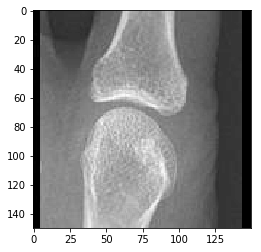

In [5]:
from matplotlib import pyplot as plt
plt.imshow(imgs[0].squeeze(), cmap = "gray")
plt.show()

In [6]:
# convert grayscale images to rgb
from IPython.display import clear_output
from PIL import Image

imgs_rgb = []

for i, img in enumerate(imgs):
    if i % 100 == 0:
        clear_output()
        print("Converting images to RGB, {0:.2f} % finished".format(i/19611*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    imgs_rgb.append(dat)

Converting images to RGB, 100.45 % finished


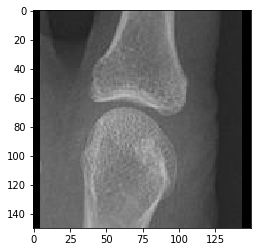

In [7]:
from matplotlib import pyplot as plt
plt.imshow(imgs_rgb[0])
plt.show()

In [8]:
imgs_rgb = np.array(imgs_rgb)
imgs_rgb.shape

(19709, 150, 150, 3)

## Get embeddings

In [9]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 150, 150, 3) dtype=float32>

In [13]:
embeddings = model.predict(imgs_rgb)

In [15]:
from sklearn.decomposition import PCA
x_50d = PCA(n_components=50).fit_transform(embeddings)

In [16]:
from sklearn.manifold import TSNE
x_2d = TSNE(n_components=2, random_state=1).fit_transform(x_50d)

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_inceptionv3.png', bbox_inches='tight')

## KNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [27]:
cv_scores = []

for k in range(1,10,2):
    print(k)
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, embeddings, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

1
3
5
7
9


In [28]:
cv_scores

[-243.2283492622725,
 -206.61570995738262,
 -198.87054957698817,
 -197.43645650653005,
 -196.82948262846301]

In [38]:
mse = [-1 * x for x in cv_scores]
mse

[243.2283492622725,
 206.61570995738262,
 198.87054957698817,
 197.43645650653005,
 196.82948262846301]

The optimal number of neighbors is 9


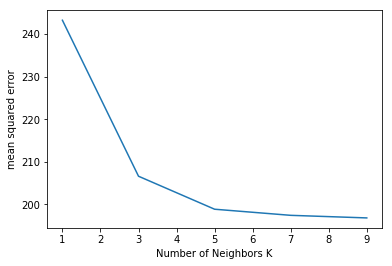

In [40]:
# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.close()
plt.plot(range(1,10,2), mse)
plt.xlabel('Number of Neighbors K')
plt.ylabel('mean squared error')
plt.show()

## 3D TSNE

In [ ]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, random_state=1).fit_transform(x_50d)

In [ ]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.savefig('/data/joint_scoring/images/tsne_3d_inceptionv3.png', bbox_inches='tight')

In [ ]:
!pip3 install scikit-image --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(50, 50)) for x in imgs]
imgs_resized = np.array(imgs_resized)

In [ ]:
n_colors = len(np.unique(y.astype("int16")))

In [ ]:
cm = plt.cm.get_cmap("viridis", n_colors)
color = np.ones((n_colors, 4))
for i in range(n_colors):
    color[i] = cm(1.*i/n_colors)

color = [np.append((x[0:-1] * 255),1) for x in color]
color = np.array(color)


color = color.astype("int16")

print(color)
print(type(color[0]))

In [ ]:
y_unique = np.unique(y.astype("int16"))
y_unique = y_unique.tolist()
print(y_unique)
y_index = y_unique.index(50)
print(y_index)

In [ ]:
from PIL import Image
from PIL import ImageMath
from IPython.display import clear_output

imgs_border = []

old_size = (50, 50)
new_size = (54, 54)

y_unique = np.unique(y.astype("int16"))
y_unique = y_unique.tolist()

for i, img in enumerate(imgs_resized):
    if i % 100 == 0:
        clear_output()
        print("Creating images with colored borders, {0:.2f} % finished".format(i/19611*100))
    old_im = Image.fromarray((img.squeeze()*255).astype("int16"))
    old_im = old_im.convert("RGB")
    y_index = y_unique.index(y[i])
    new_im = Image.new("RGB", new_size, tuple(color[int(y_index)]))
    new_im.paste(old_im, (2,2))
    dat = np.asarray(a=new_im)
    imgs_border.append(dat)

In [ ]:
plt.imshow(imgs_border[1])
plt.show()

In [ ]:

res = 8000 # resolution of plot
cval = 255 # background colour

images = imgs_border
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [ ]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [ ]:
res_x, res_y

In [ ]:
res_y=res_y.astype("int16")

In [ ]:
images[0].shape

In [ ]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611*100))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

In [ ]:
plt.figure(figsize=(400,400))
plt.imshow(canvas)
plt.savefig('/data/joint_scoring/images/embeddings_inceptionv3.png', bbox_inches='tight')